In [1]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import ast

/home/max/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
importlib.reload(rr)

dfs = []
for path in [("ProtonBeam","all"),("COPD","copd")]:
    document_index = rr.parse_pb_xml(f'../data/{path[0]}/{path[1]}.xml')
    document_index = document_index.drop_duplicates()
    document_index['rec-number'] = document_index['rec-number'].astype(int)
    
    relevant_index = pd.read_csv(
    f'../data/{path[0]}/relevant.txt',header=None,
    names=["rec-number"])
    
    relevant_index['relevant'] = 1
    
    df = pd.merge(
        document_index,
        relevant_index,
        how="left"
    )
    
    df['review'] = path[0]
    dfs.append(df)
    
df = pd.concat(dfs)
df['relevant'] = df['relevant'].fillna(0)    
df.head()

,ab,rec-number,ti,relevant,review
0,None,2201,Proton radiation for acromegaly,0.0,ProtonBeam
1,Particle radiation therapy has the potential f...,2202,Particle radiation therapy,0.0,ProtonBeam
2,The Program for Particle Therapy proposes util...,2203,Proposal for a program in particle-beam radiat...,0.0,ProtonBeam
3,None,2204,[Congress on linear accelerators: radioprotect...,0.0,ProtonBeam
4,None,2205,Particle accelerators in radiation therapy. Pr...,0.0,ProtonBeam


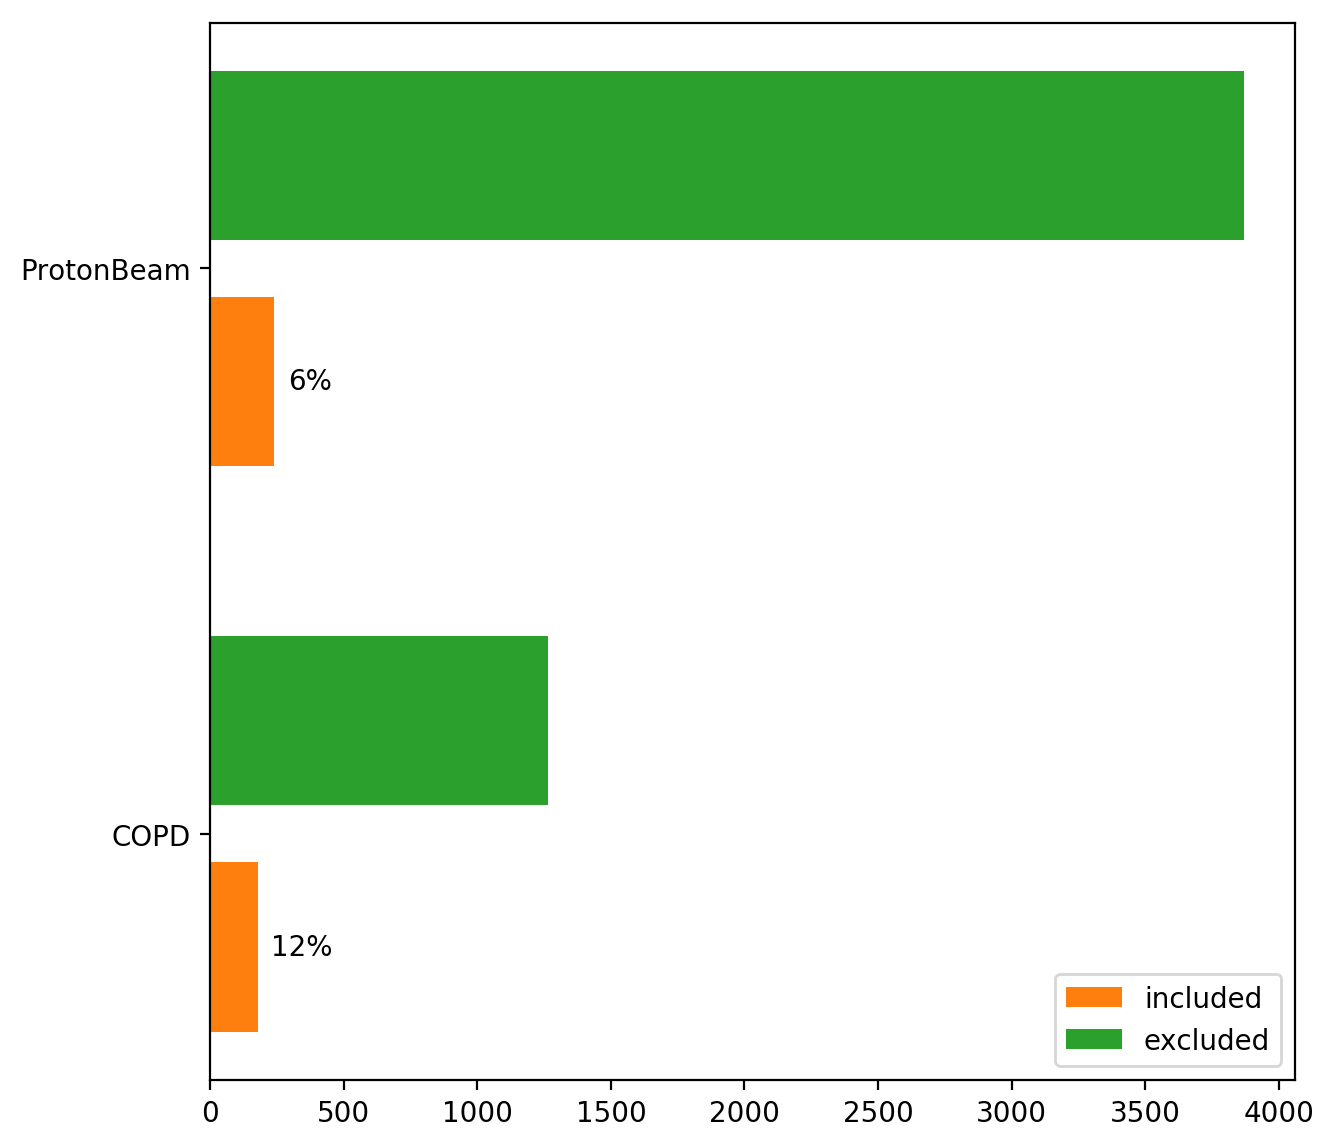

In [3]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(df.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/(included+excluded):.0%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

[Text(0, 0, '0.0'), Text(0, 0, '1.0')]

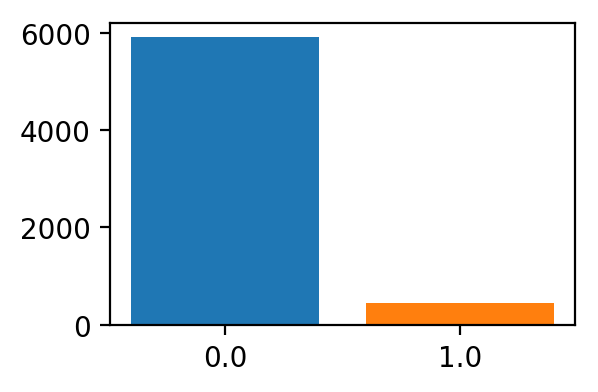

In [4]:
fig, ax = plt.subplots(figsize=(3,2),dpi=200)

ticks = []
labels = []
for i, (name, group) in enumerate(df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ticks.append(i)
    labels.append(name)
    
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

Dataset: COPD, iteration 0.  1443 out of 1443 documents seen (100%) - recall: 100.00%, probable recall: 0.00%
error rate: 0%


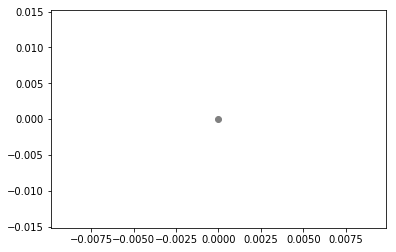

(1, 66)


,dataset,models,N,r_docs,p,bir,bir_upperbound,seen_docs,r_seen,r_predicted,...,hypothetical_95,hyper_prob_pmf,hyper_prob,hyper_interval,recall_rs,recall_hyper,recall_ih_50,recall_ih_100,recall_nrs,recall_ih_200
0,COPD,"[SVC(C=1.0, cache_size=200, class_weight='bala...",1443,179,0.124047,0.096667,0.135761,1443,179,139,...,18.0,0.0,0.0,"(18.0, 18.0)",0.960894,0.960894,0.955307,0.994413,0.994413,0.994413


In [35]:
importlib.reload(rr)
import time

results = []
iterations = 1

df['x'] = df['ab']

recalculate = True
error_count = 0
if recalculate:
    for name, group in df.groupby('review'):
        group = group.dropna().reset_index(drop=True)

        if name != "COPD":
            continue
        models = [
            SVC(kernel='linear',class_weight='balanced',probability=True)
            #MultinomialNB(alpha=0.1)    
            #MLPClassifier(
            #    solver='lbfgs', 
            #    alpha=0.1,
            #    hidden_layer_sizes=(10), 
            #    random_state=1
            #)
        ]

        ss = rr.ScreenScenario(
            group, models, 300, [50,100,200], name
        )
        for i in range(iterations):
            results.append(ss.screen(i, True, True))
            if ss.recall_hyper < 0.95:
                error_count +=1
                
                
                
            print(f"error rate: {error_count/(i+1):.0%}")
            time.sleep(1)
            plt.scatter(i, error_count/(i+1), c="grey")

    results_df = pd.DataFrame.from_dict(results)
    plt.show()
else:
    results_df = pd.read_csv('../results/results_pb_copd.csv') 
    #for p in ["estimated_recall_path", "recall_track", "work_track","random_work_track","random_recall_track"]:
    for p in results_df.columns:
        if "path" in p or "track" in p:
            results_df[p] = results_df[p].apply(ast.literal_eval)
    
    
print(results_df.shape)
results_df.head()


In [120]:
results_df = pd.DataFrame.from_dict(results)
results_df.head()

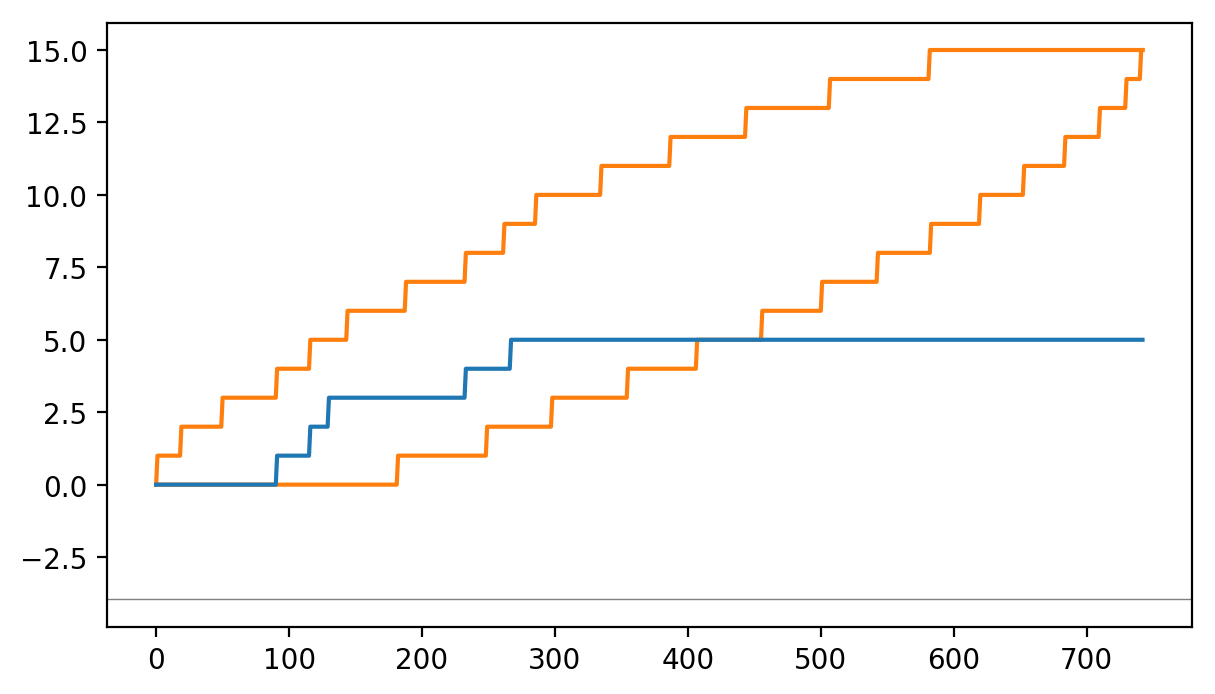

In [31]:
self = ss

fig, axs = plt.subplots(figsize=(7,4),dpi=200)

plt.plot(self.hyper_linterval_path, c="C1")
plt.plot(self.hyper_uinterval_path, c="C1")
plt.plot(self.X_sample_path)



plt.axhline(self.r_docs*0.95 - self.r_seen + self.X_sample, zorder=-5, lw=0.5, c="grey")




In [ ]:
fig, axs = plt.subplots(figsize=(7,4),dpi=200)

for i, r in results_df.iterrows():
    plt.plot(r['hyper_linterval_path'], c="C1", alpha=0.5)
    plt.plot(r['hyper_uinterval_path'], c="C1", alpha=0.5)
    plt.plot(r['X_sample_path'], c = "C2", alpha=0.5)
    

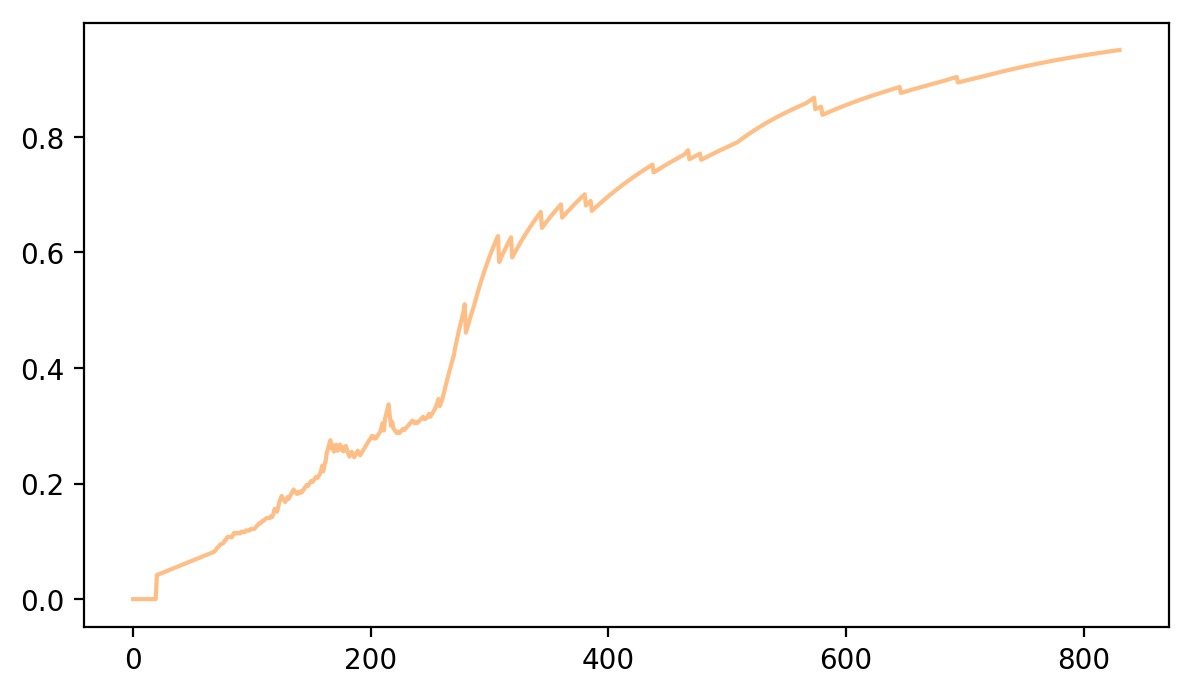

In [36]:
fig, axs = plt.subplots(figsize=(7,4),dpi=200)

for i, r in results_df.iterrows():
    plt.plot(r['max_min_recall_path'], c="C1", alpha=0.5)

    

In [21]:
print(self.r_seen)

print(self.X_sample)
print(f"sample size - {self.n_sample}")
print(f"n remaining - {self.n_remaining}")
print(f"95 - hypothetical - {self.hypothetical_95}")

179
5.0
sample size - 763
n remaining - 0
95 - hypothetical - 15.0


0.8


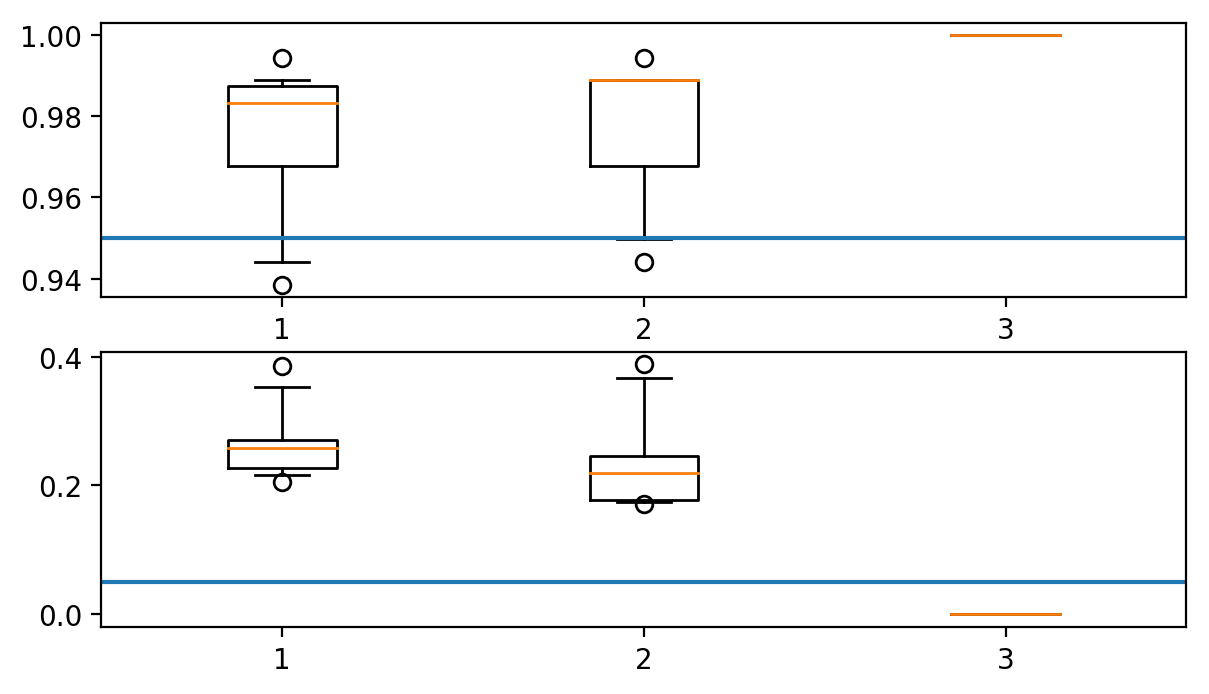

In [22]:
fig, axs = plt.subplots(2,figsize=(7,4),dpi=200)

ax = axs[0]

ax.boxplot([results_df['recall_rs'].dropna(), results_df['recall_hyper'], results_df['recall_nrs'] ], whis=[5, 95])

ax.axhline(0.95)

ax = axs[1]

ax.boxplot([results_df['wss95_rs'].dropna(), results_df['wss95_hyper'], results_df['wss95_nrs'] ], whis=[5, 95])

ax.axhline(0.05)

print(results_df[results_df['recall_hyper'] >= 0.95].shape[0] / results_df.shape[0])


In [43]:
import math
math.ceil(self.r_seen / 0.95 + 0.01) - self.r_seen + self.X_sample


91.0

In [16]:
import random
iterations = 10#00
sims = []
for i in range(iterations):
    for p in np.array(range(1,10))*0.01:
        for N in [200, 500, 1000, 2000]:
            true_X = N*p
            true_X = round(true_X+random.random()*10-5)
            docs = [1]*int(true_X) + [0]*int(N-true_X)
            random.shuffle(docs)
            for s in [500, 1000]:
                if s >= N:
                    continue
                sample = random.sample(docs, s)
                random.shuffle(sample)
                X = 0
                for j, x in enumerate(sample):
                    X += x
                    p_tilde, ci = rr.ci_ac(X, j+1, 0.95)
                    ui = (p_tilde+ci)*N
                    n_remaining = N - (j+1)
                    ui_remaining = (p_tilde+ci)*n_remaining + X
                    error_remaining = ui_remaining/true_X
                    sims.append({
                        "N":N, "p": p, "true_X": true_X,
                        "s": s, "j": j,  "p_tilde": p_tilde,
                        "ci": ci, "ui": ui, "error": ui/true_X,
                        "ui_remaining": ui_remaining, "error_remaining": error_remaining
                    })
                    
                    
sim_df = pd.DataFrame.from_dict(sims)

KeyboardInterrupt: 

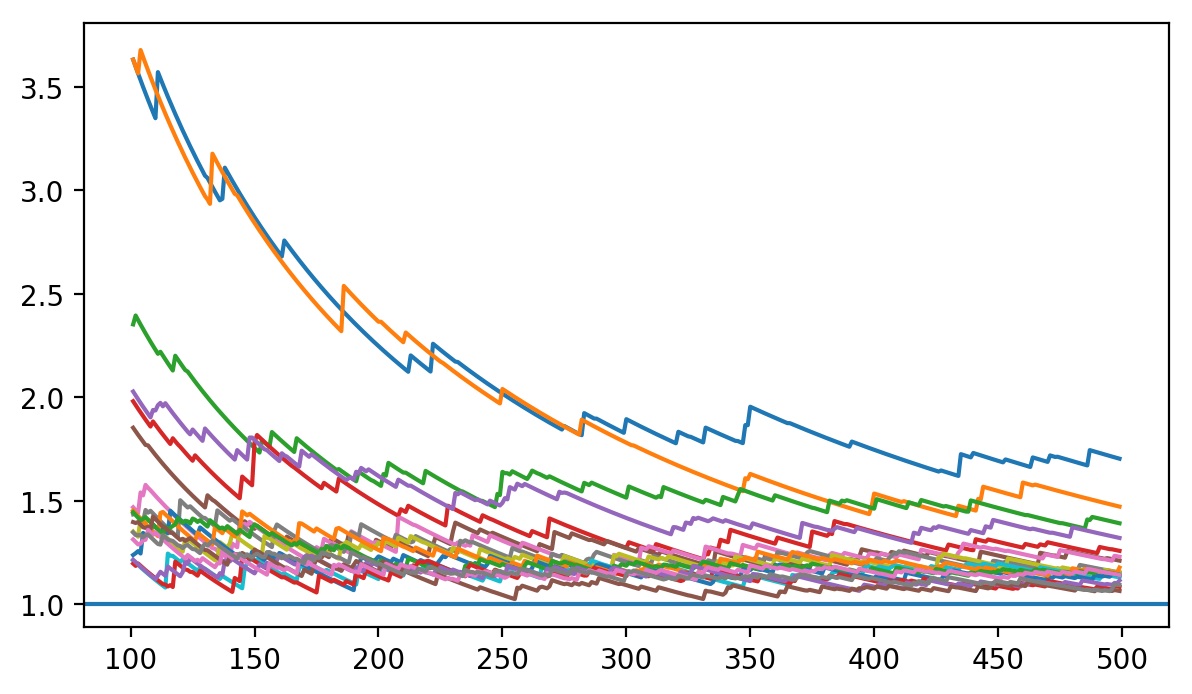

In [94]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

for name, group in sim_df.groupby('p'):
    for name2, group2 in group.groupby('N'):
        ax.plot(group2[group2['j']>100].groupby('j')['error'].quantile(0.05))
    
ax.axhline(1)
    
plt.show()

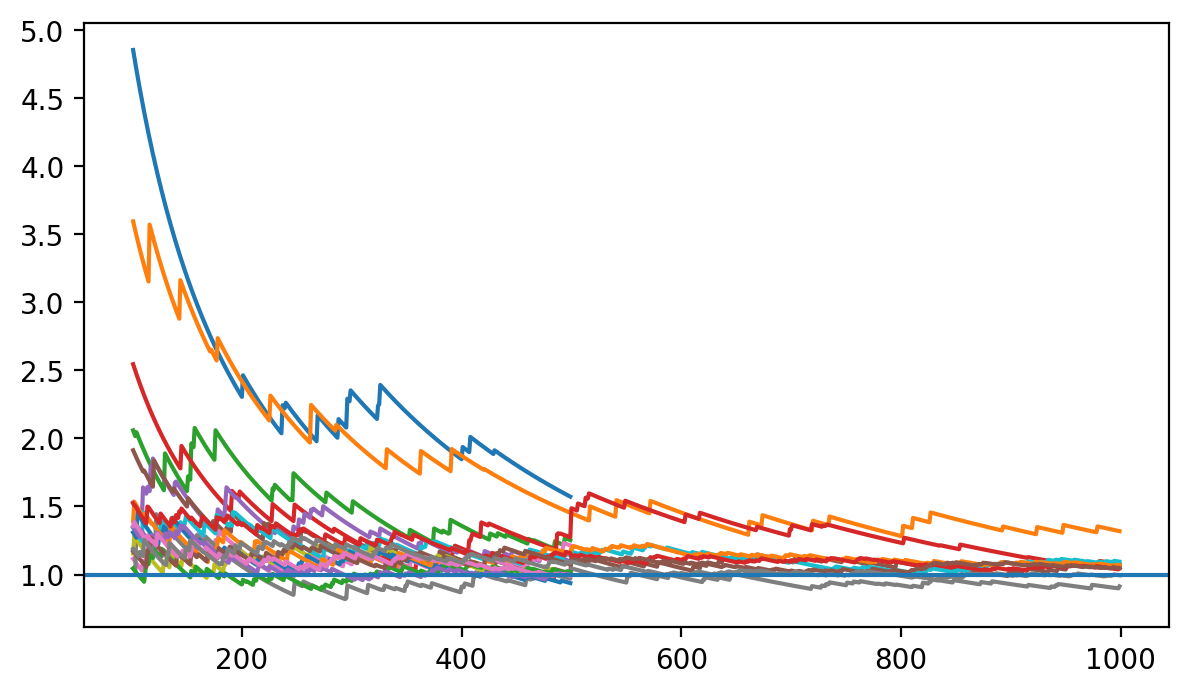

In [113]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

for name, group in sim_df.groupby('p'):
    for name2, group2 in group.groupby('N'):
        ax.plot(group2[group2['j']>100].groupby('j')['error_remaining'].quantile(0.05))
    
ax.axhline(1)
    
plt.show()

In [12]:
results_df[results_df['recall_rs'] < 0.95][['r_seen_pre_sample','estimated_r_docs','r_seen','r_docs','n_remaining','seen_docs','N','estimated_p_ub','estimated_recall_min','X_sample','n_sample']]

,r_seen_pre_sample,estimated_r_docs,r_seen,r_docs,n_remaining,seen_docs,N,estimated_p_ub,estimated_recall_min,X_sample,n_sample
2,60,176.830335,168,179,72,1371,1443,0.122544,0.950063,108.0,1051
5,75,177.777333,169,179,79,1364,1443,0.123200,0.950627,94.0,1024
7,67,178.880632,170,179,74,1369,1443,0.123964,0.950354,103.0,1029
8,113,175.739528,167,179,116,1327,1443,0.121788,0.950270,54.0,927
9,81,178.931783,170,179,84,1359,1443,0.124000,0.950083,89.0,1019
11,40,177.832260,169,179,63,1380,1443,0.123238,0.950334,129.0,1080
14,78,177.876335,169,179,82,1361,1443,0.123268,0.950098,91.0,1021
18,51,178.926655,170,179,67,1376,1443,0.123996,0.950110,119.0,1056


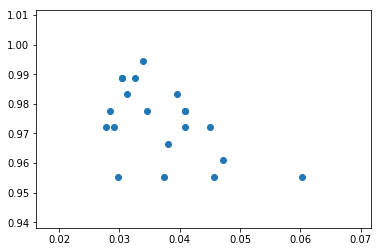

In [141]:
plt.scatter(results_df['wss95_hyper'], results_df['recall_hyper'])

/home/max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/max/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


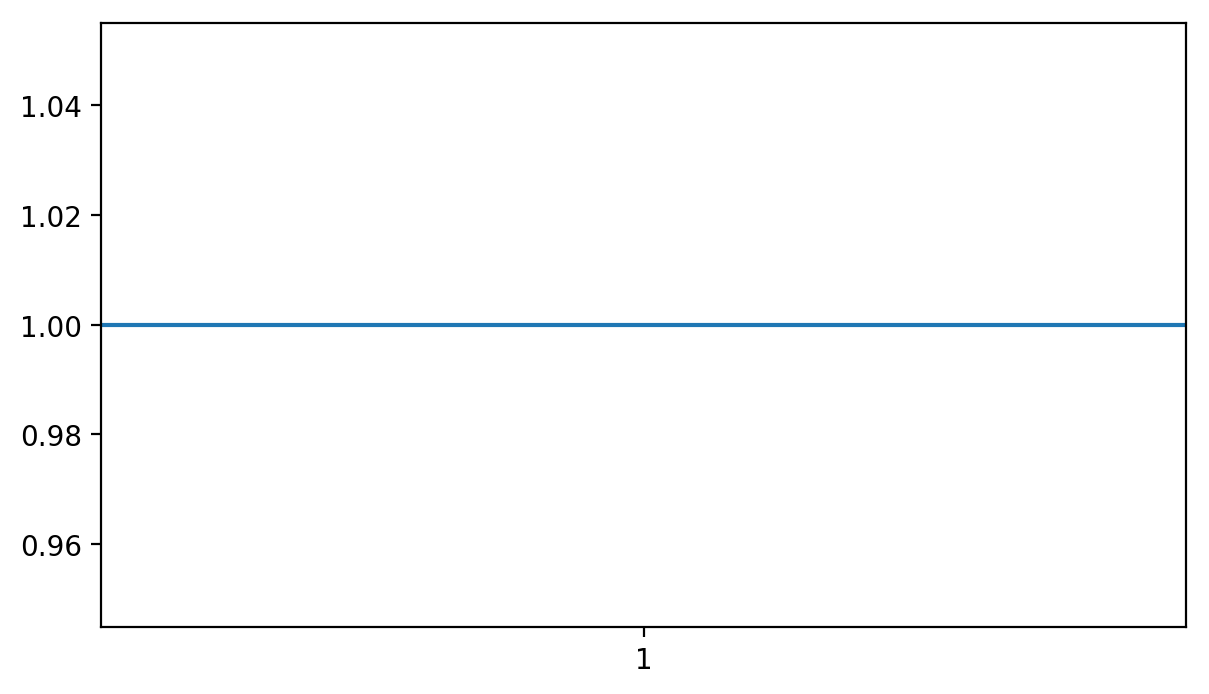

In [142]:
results_df['r_remaining'] = results_df['r_docs'] - results_df['r_seen']
results_df['estimated_r_remaining'] = results_df['estimated_r_docs'] - results_df['r_seen']



fig, ax = plt.subplots(figsize=(7,4),dpi=200)
ax.boxplot(results_df['estimated_r_remaining'] / results_df['r_remaining'])
ax.axhline(1)
plt.show()

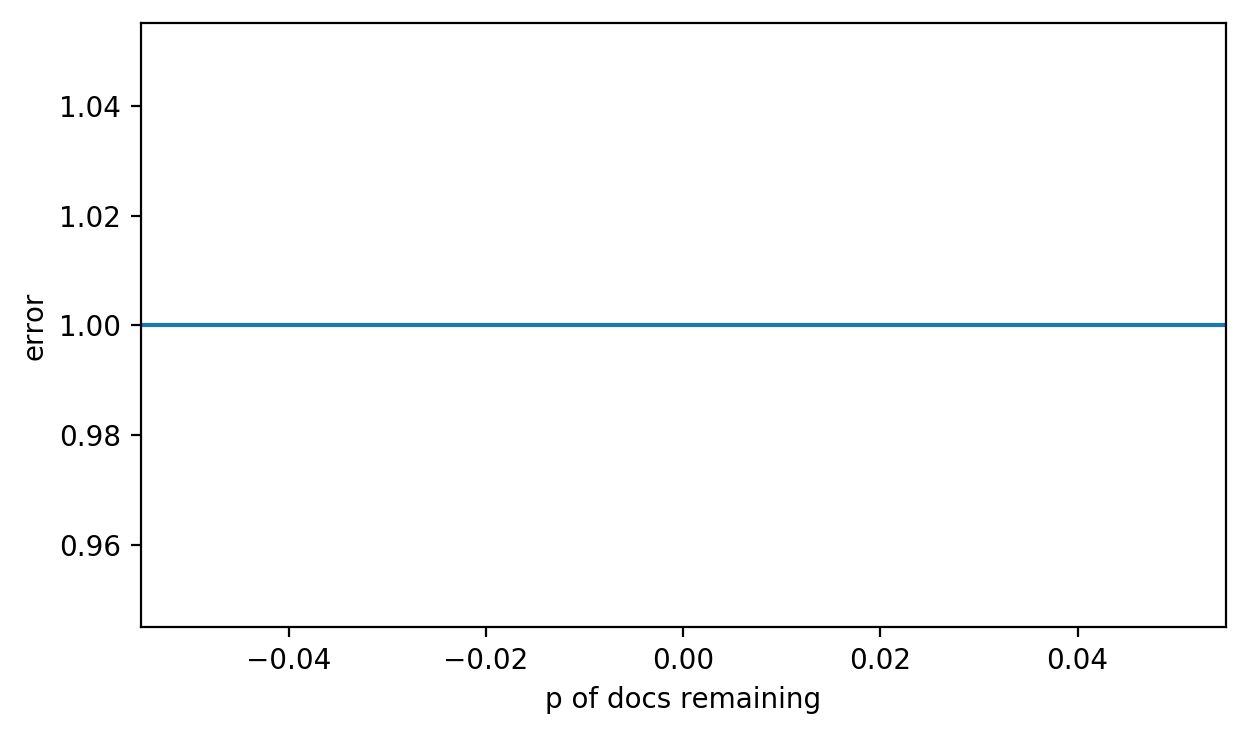

In [143]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
ax.scatter(results_df['r_remaining']/results_df['n_remaining'],results_df['estimated_r_remaining'] / results_df['r_remaining'])

ax.set_xlabel('p of docs remaining')
ax.set_ylabel('error')

ax.axhline(1)
plt.show()

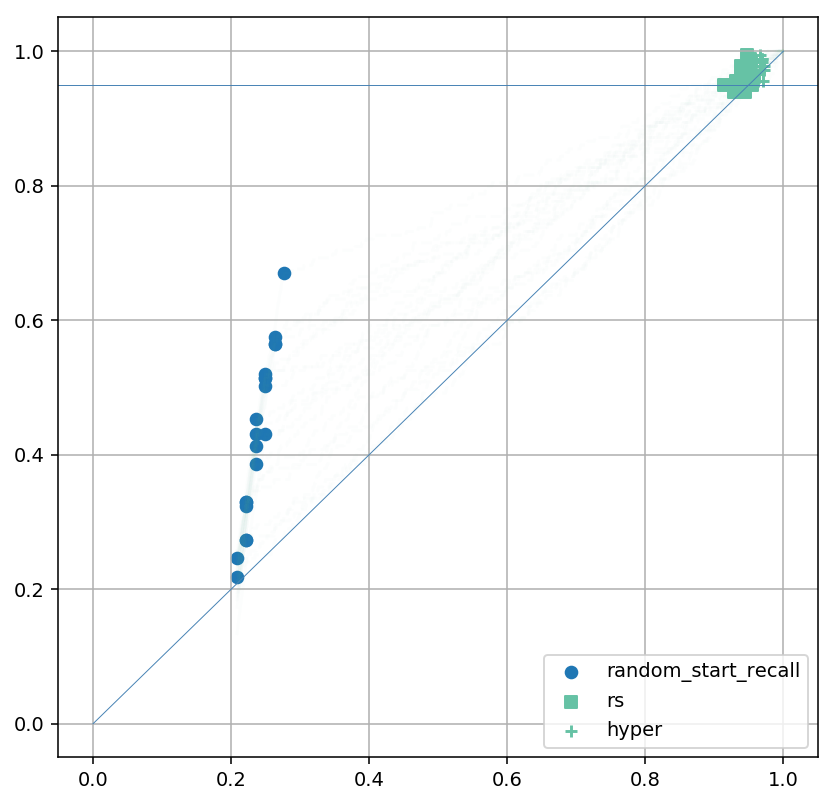

In [144]:


fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.02

pdf = results_df[results_df['N'] > 1000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--")
    #ax.plot(p['random_work_track'], p['estimated_recall_path'])
    
s_crit = ["rs","hyper"]

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

ax.scatter(pdf['random_start_work'],pdf['random_start_recall'])

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss95_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()

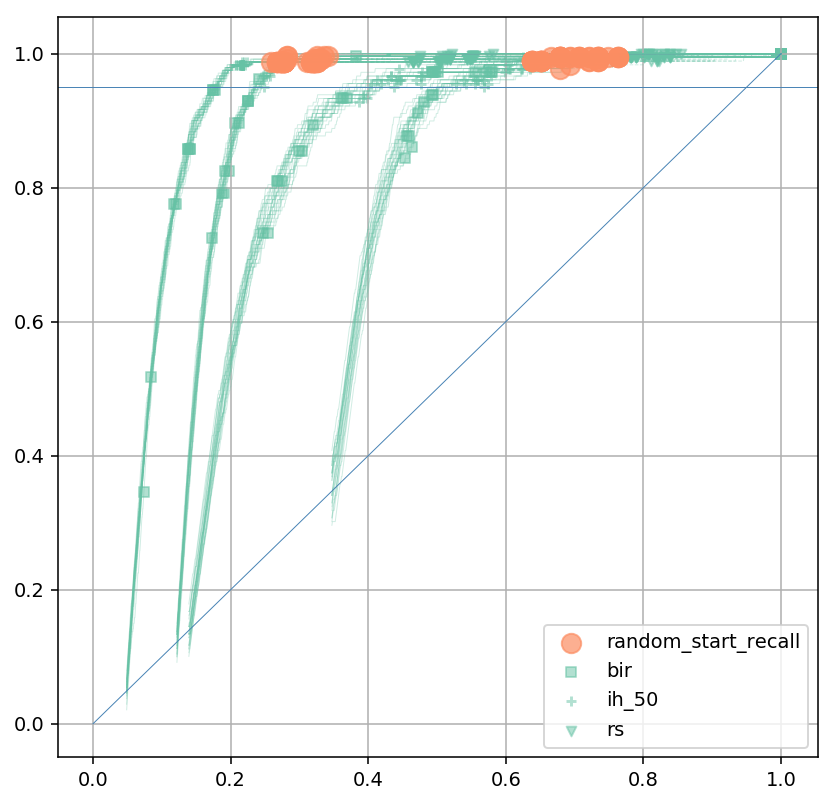

In [7]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.3
size = 25

pdf = results_df[results_df['N'] > 1000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a, lw=0.5)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--", lw=0.5)
    #ax.plot(p['random_work_track'], p['estimated_recall_path'])
    
s_crit = ["bir","ih_50","rs"]

import itertools
marker = itertools.cycle((',', '+', 'v', 'o', '*')) 

ax.scatter(pdf['random_start_work'],pdf['random_start_recall'],c=colors[1],s=size*4,alpha=a+0.4, zorder=5)

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss95_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s,
        s = size,
        alpha=a+0.2
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()

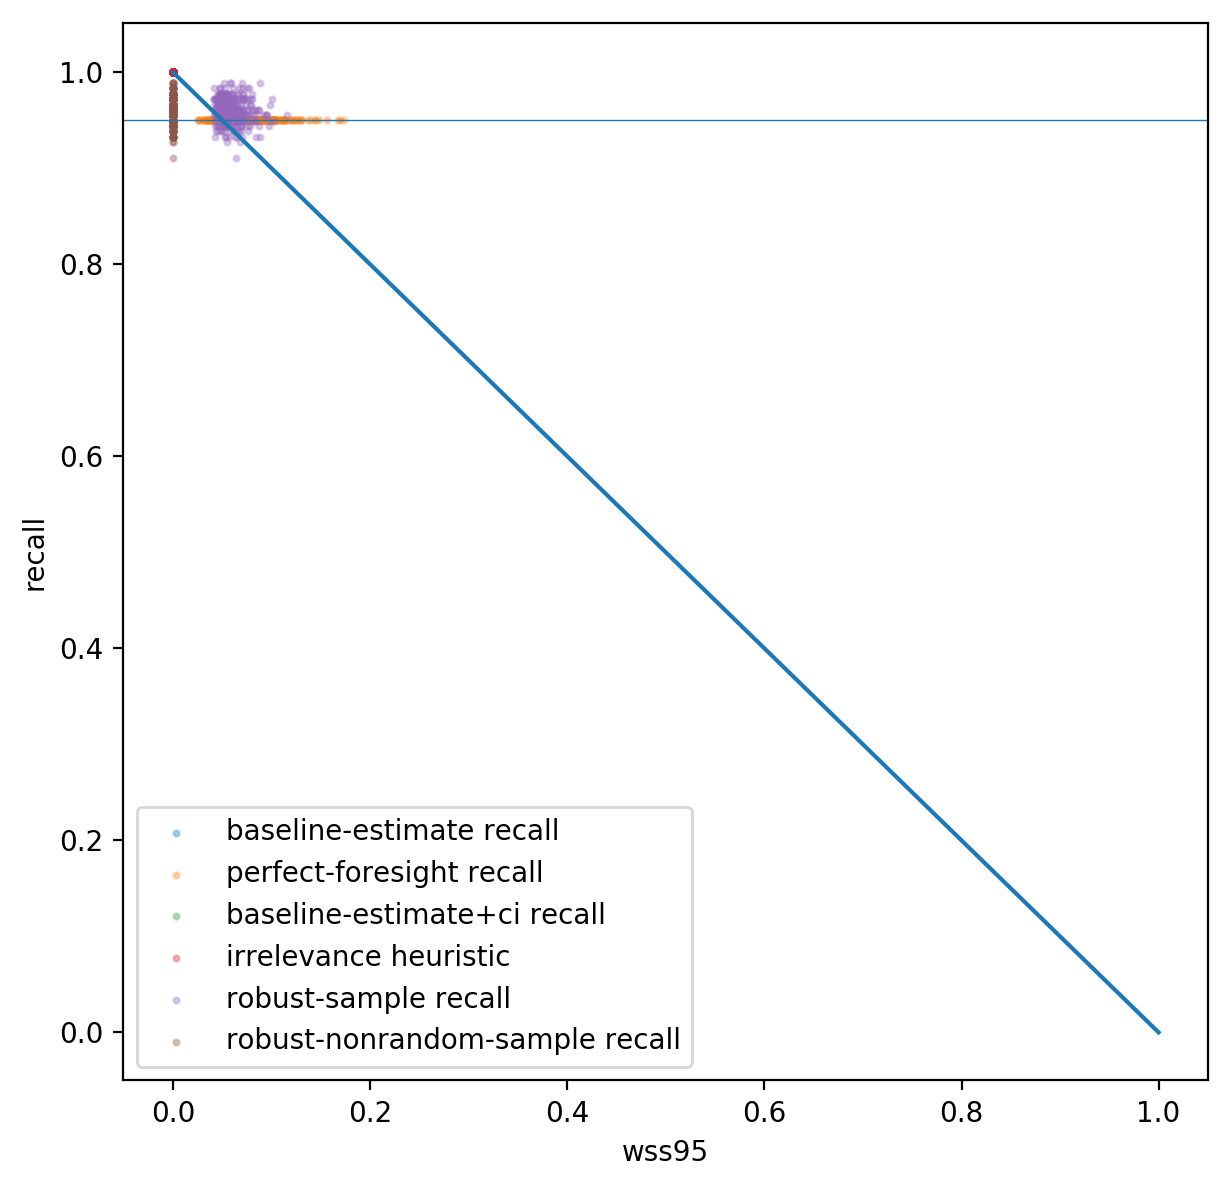

In [128]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
s = 4
a = 0.3
ax.scatter(
    results_df['wss95_bir'], results_df['recall_bir'], 
    alpha=a, 
    label="baseline-estimate recall",
    s=s
)
ax.scatter(
    results_df['wss95_pf'], 
    [0.95 for x in results_df['recall_pf']], 
    alpha=a,
    label="perfect-foresight recall",
    s=s
)

ax.scatter(
    results_df['wss95_bir_ci'], 
    results_df['recall_bir_ci'], 
    alpha=a,
    label="baseline-estimate+ci recall",
    s=s
)

ax.scatter(
    results_df['wss95_ih_50'], 
    results_df['recall_ih_50'], 
    alpha=a,
    label="irrelevance heuristic",
    s=s
)

ax.scatter(
    results_df['wss95_rs'], results_df['recall_rs'], 
    alpha=a, 
    label="robust-sample recall",
    s=s
)

ax.scatter(
    results_df['wss95_nrs'], results_df['recall_rs'], 
    alpha=a, 
    label="robust-nonrandom-sample recall",
    s=s
)

ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.plot([1,0],)

ax.axhline(0.95, lw=0.5)
plt.show()

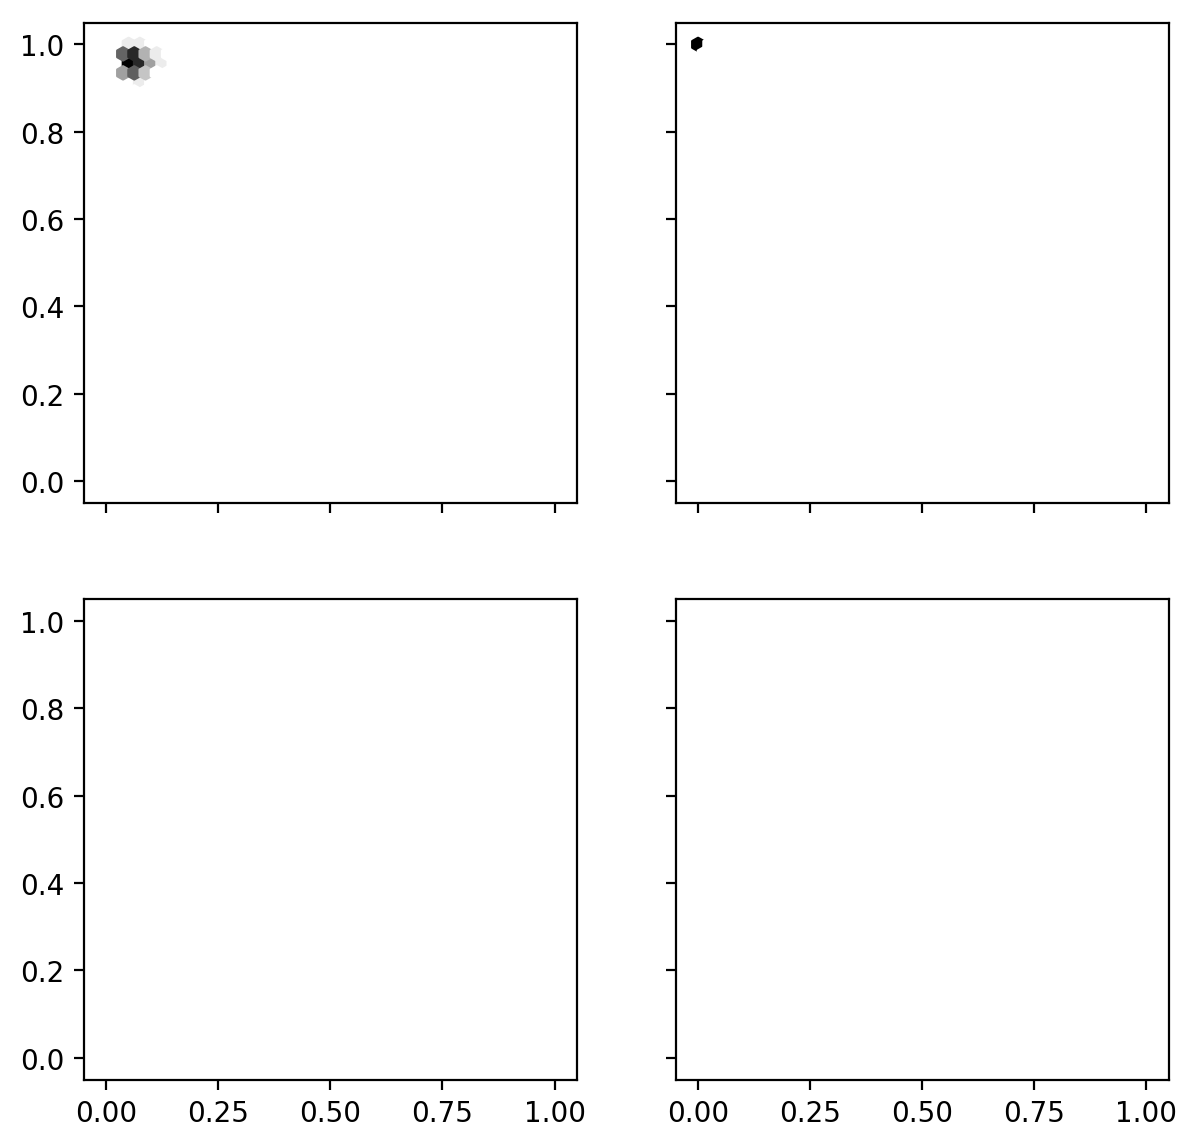

In [131]:
fig, axs = plt.subplots(2,2,figsize=(7,7),dpi=200,sharey=True, sharex=True)


for i, ss in enumerate(['_rs','_hyper']):
    ax = axs[i//2][i%2]
    ax.hexbin(
        results_df[f'wss95{ss}'], 
        results_df[f'recall{ss}'], 
        gridsize=40, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
plt.show()    

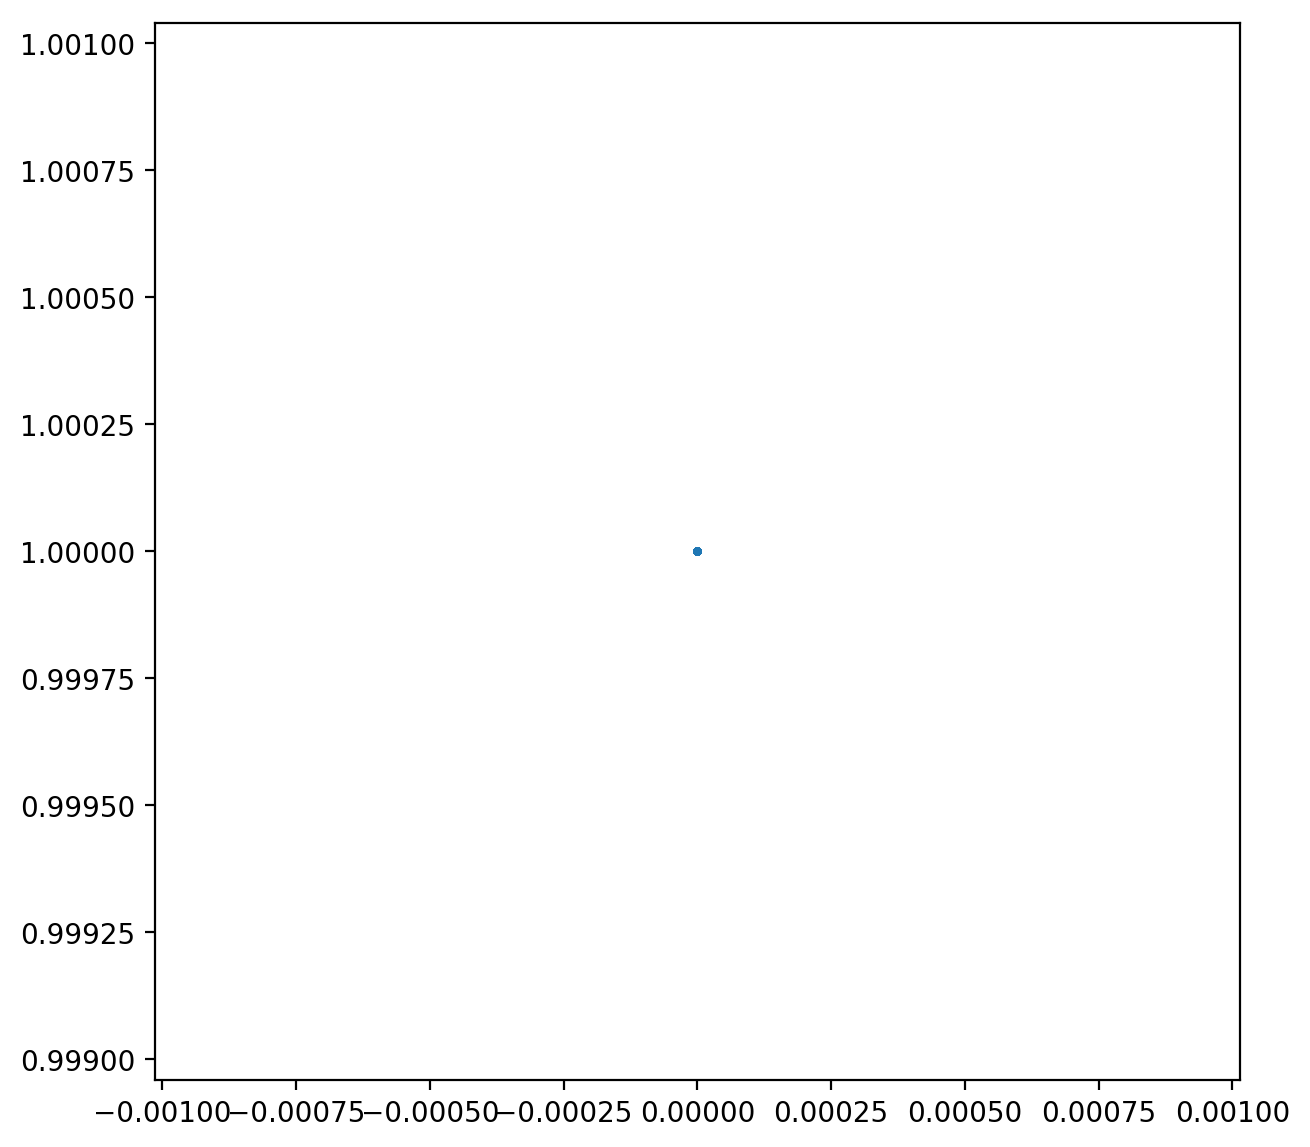

In [134]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
s = 4
a = 0.3
ax.scatter(
    results_df['wss95_hyper'], results_df['recall_hyper'], 
    alpha=a, 
    label="baseline-estimate recall",
    s=s
)